## Import các thư viện cần thiết

In [1]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, confusion_matrix,accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
from sklearn.metrics import roc_auc_score, roc_curve,precision_recall_curve,precision_score,recall_score,f1_score

## Đọc dữ liệu huấn luyện

In [2]:
with open('train.json') as f:
    train_data = json.load(f)

In [3]:
train_df=pd.DataFrame(train_data)
train_df

,audio_embedding,is_turkey,vid_id,end_time_seconds_youtube_clip,start_time_seconds_youtube_clip
0,"[[172, 34, 216, 110, 208, 46, 95, 66, 161, 125...",0,kDCk3hLIVXo,70,60
1,"[[169, 20, 165, 102, 205, 62, 110, 103, 211, 1...",1,DPcGzqHoo7Y,40,30
2,"[[148, 8, 138, 60, 237, 48, 121, 108, 145, 177...",1,7yM63MTHh5k,240,230
3,"[[151, 0, 162, 88, 171, 71, 47, 90, 179, 190, ...",1,luG3RmUAxxM,520,510
4,"[[162, 17, 187, 111, 211, 105, 92, 67, 203, 15...",0,PIm3cjxTpOk,10,0
...,...,...,...,...,...
1190,"[[90, 105, 224, 173, 117, 88, 119, 2, 219, 59,...",0,AKIWjFmAMt8,30,20
1191,"[[132, 154, 242, 164, 181, 58, 154, 63, 163, 4...",0,QTRCw0xn6uc,40,30
1192,"[[148, 8, 171, 123, 241, 91, 126, 154, 96, 246...",1,DbJJoQfo3kc,40,30
1193,"[[166, 13, 201, 135, 190, 93, 71, 30, 139, 151...",0,opqJ1SZmyGk,200,190


## Đọc dữ liệu test

In [4]:
with open('test.json') as f:
    test_data = json.load(f)

In [5]:
test_df=pd.DataFrame(test_data)
test_df

,audio_embedding,vid_id,end_time_seconds_youtube_clip,start_time_seconds_youtube_clip
0,"[[177, 20, 226, 132, 198, 81, 111, 59, 132, 18...",pyKh38FXD3E,10,0
1,"[[169, 21, 204, 161, 195, 72, 60, 39, 152, 184...",THhP1idrWXA,40,30
2,"[[165, 13, 198, 141, 199, 81, 173, 54, 119, 11...",jsw3T6GY2Nw,40,30
3,"[[167, 18, 188, 159, 198, 63, 156, 36, 179, 22...",nFkXTMHcjMU,24,14
4,"[[178, 32, 181, 100, 198, 46, 82, 83, 136, 227...",Au8g9kAlrLQ,40,30
...,...,...,...,...
1191,"[[153, 26, 118, 69, 255, 87, 153, 59, 125, 204...",lQOQR6HCGyE,11,1
1192,"[[159, 8, 163, 128, 172, 64, 36, 56, 110, 236,...",CqhPMjumTOA,40,30
1193,"[[78, 56, 132, 20, 92, 120, 6, 133, 191, 156, ...",Ccn2LQJc2MI,40,30
1194,"[[81, 115, 208, 104, 236, 91, 95, 71, 161, 152...",f6OhmrIdB-g,40,30


## Khám phá dữ liệu

- Các cột có trong dữ liệu huấn luyện.

In [6]:
train_df.columns

Index(['audio_embedding', 'is_turkey', 'vid_id',
       'end_time_seconds_youtube_clip', 'start_time_seconds_youtube_clip'],
      dtype='object')

Trong đó, các cột cần sử dụng trong việc huấn luyện sẽ là audio_embedding, is_turkey.

- Các cột có trong dữ liệu test.

In [7]:
test_df.columns

Index(['audio_embedding', 'vid_id', 'end_time_seconds_youtube_clip',
       'start_time_seconds_youtube_clip'],
      dtype='object')

Dựa vào yêu cầu, các cột sử dụng trong tập dữ liệu này là audio_embedding và vid_id.

- Số lượng các label trong tập dữ liệu huấn luyện.

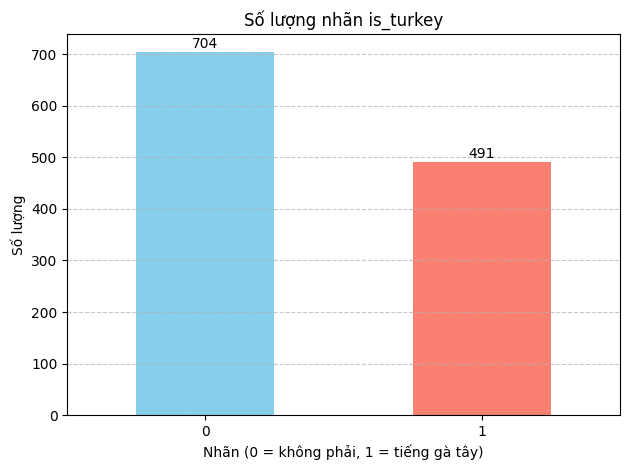

In [8]:
label_counts=train_df['is_turkey'].value_counts()

ax = label_counts.plot(kind='bar', color=['skyblue', 'salmon'])

for i, v in enumerate(label_counts):
    ax.text(i, v + 1, str(v), ha='center', va='bottom')

plt.title('Số lượng nhãn is_turkey')
plt.xlabel('Nhãn (0 = không phải, 1 = tiếng gà tây)')
plt.ylabel('Số lượng')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

Số lượng nhãn 0 nhiều hơn số lượng nhãn 1.

- Kiểm tra min và max trong từng audio_embedding trong tập dữ liệu huấn luyện.

In [9]:
all_values = np.concatenate([np.array(x).flatten() for x in train_df['audio_embedding']])

print('Max of audio_embedding:',np.max(all_values))
print('Min of audio_embedding:',np.min(all_values))

Max of audio_embedding: 255
Min of audio_embedding: 0


Giá trị lớn nhất và giá trị nhỏ nhất là 255 và 0 do đó để việc huấn luyện dễ dàng hơn ta cần thực hiện chuẩn hóa.

- Xem audio_embedding có số lượng frame khác nhau không?

In [10]:

audio_embedding=train_df['audio_embedding']
length_frames=audio_embedding.apply(lambda x: len(x))
length_frames.unique()


array([10,  9,  2,  3,  8,  5,  6,  7,  4])

Vậy trong tập dữ liệu có chứa số lượng khác nhau.

- Số đặc trưng của một frame.

In [11]:
frame_dims = train_df['audio_embedding'].apply(lambda x: len(x[0]) if len(x) > 0 else -1)

print("Các số chiều khác nhau tìm thấy:", frame_dims.unique())

Các số chiều khác nhau tìm thấy: [128]


Vậy tất cả frame đều có 128 chiều.

- In ra một số audio_embedding của một vài dòng dữ liệu bằng heatmap.

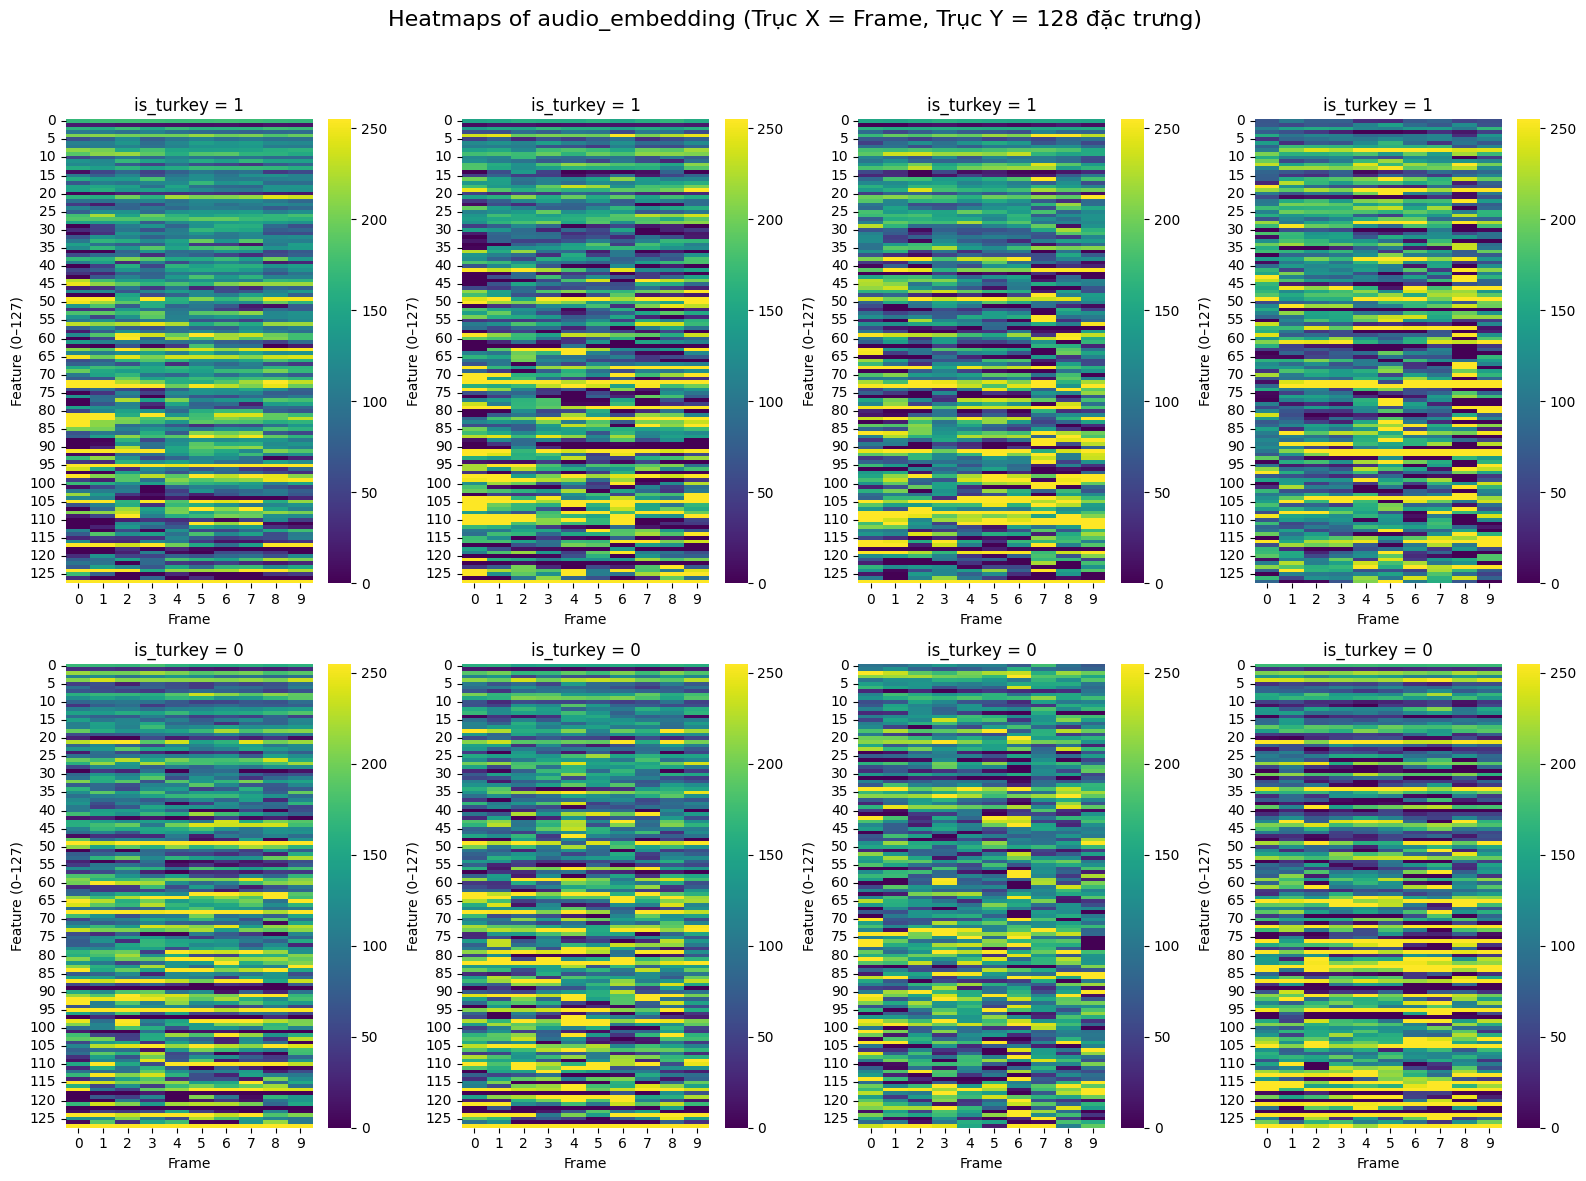

In [12]:
import seaborn as sns

samples_1 = train_df[train_df['is_turkey'] == 1].head(4).to_dict(orient='records')
samples_0 = train_df[train_df['is_turkey'] == 0].head(4).to_dict(orient='records')
# Gộp lại
selected_samples = samples_1 + samples_0

# Vẽ heatmap 
plt.figure(figsize=(16, 12))
for i, sample in enumerate(selected_samples):
    embedding = sample['audio_embedding']
    embedding_T = list(zip(*embedding))  # Transpose ma trận

    plt.subplot(2, 4, i + 1)
    sns.heatmap(embedding_T, cmap='viridis')
    plt.title(f"is_turkey = {sample['is_turkey']}")
    plt.xlabel("Frame")  # Trục hoành
    plt.ylabel("Feature (0–127)")  # Trục tung

plt.suptitle("Heatmaps of audio_embedding (Trục X = Frame, Trục Y = 128 đặc trưng)", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

## Xử lý đặc trưng dữ liệu

- Vì mỗi audio_embedding có số lượng frame khác nhau do đó để dễ dàng trong việc huấn luyện ta thực hiện lấy trung bình của mỗi đặc trưng trong các frame.

In [13]:
def combined_features(embedding): # Hàm tính đặc trưng kết hợp.
    x=np.array(embedding)
    return np.mean(x, axis=0)

In [14]:
train_X = np.stack(train_df['audio_embedding'].apply(combined_features))
train_Y = train_df['is_turkey'].values


- Chuẩn hóa dữ liệu

In [15]:
scaler = StandardScaler()
Z = scaler.fit_transform(train_X)

## Giảm chiều dữ liệu bằng PCA

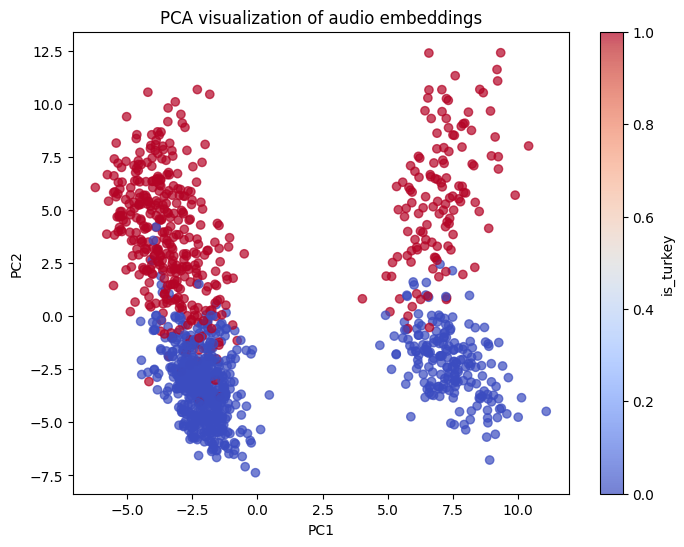

In [16]:
from sklearn.decomposition import PCA

PCA_model = PCA(n_components=2)
X_pca = PCA_model.fit_transform(Z)

plt.figure(figsize=(8,6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=train_Y, cmap='coolwarm', alpha=0.7)
plt.title("PCA visualization of audio embeddings")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.colorbar(label='is_turkey')
plt.show()

- Dựa vào biểu đồ trên, dữ liệu phân thành hai cụm rõ rệt:
    - Cụm nhãn 1(màu đỏ) nằm phía trên.
    - Cụm nhãn 0(màu xanh) nằm phía dưới.

$\rightarrow$ Cho thấy việc sử dụng trung bình đủ để phân biệt giữa "1" và "0". Do đó việc sử dụng mô hình như Logistic Regression, SVM, RandomForest,... sẽ đạt được độ chính xác cao.

## Giảm chiều dữ liệu bằng t-SNE

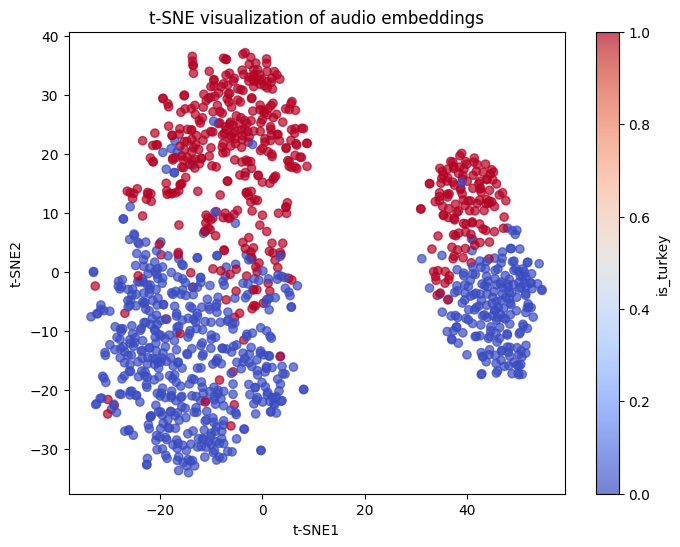

In [17]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)

X_tsne = tsne.fit_transform(Z)

plt.figure(figsize=(8,6))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=train_Y, cmap='coolwarm', alpha=0.7)
plt.title("t-SNE visualization of audio embeddings")
plt.xlabel("t-SNE1")
plt.ylabel("t-SNE2")
plt.colorbar(label='is_turkey')
plt.show()

- Một số điểm nằm xen kẽ, nhưng phần lớn đã được tách biệt rõ ràng.
- Dễ dàng nhận ra hai cụm chính tương tự như PCA:
    - Cụm màu đỏ nằm ở phần trên.
    - Cụm màu xanh nằm ở phần dưới.

## Phân cụm bằng KMeans sau khi sử dụng PCA.

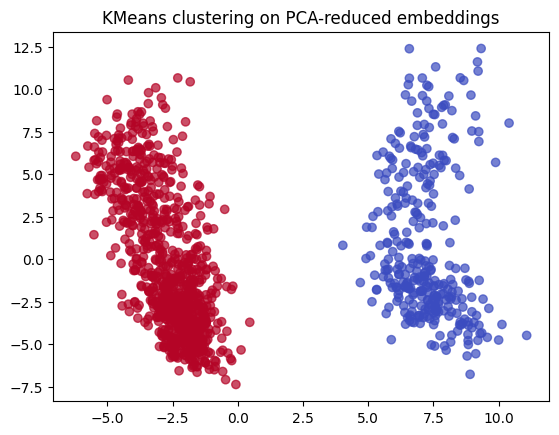

In [18]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=2, random_state=42)
clusters = kmeans.fit_predict(X_pca)

plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters, cmap='coolwarm', alpha=0.7)
plt.title("KMeans clustering on PCA-reduced embeddings")
plt.show()



- Đánh giá KMeans.

In [19]:
from sklearn.metrics import adjusted_rand_score


ari = adjusted_rand_score(train_Y, clusters)
print(f"ARI score: {ari:.3f}")

ARI score: -0.004


ARI score -0.004 nghĩa là cho biết rằng KMeans clustering gần như không khớp gì với nhãn thật is_turkey. Có thể KMeans không biết đâu là nhãn 0 và nhãn 1 do đó cần đảo nhãn.

In [20]:
clusters_flipped = 1 - clusters

# Tính lại ARI
ari = adjusted_rand_score(train_Y, clusters_flipped)
print(f"ARI (flipped) score: {ari:.3f}")

ARI (flipped) score: -0.004


Sau khi tính lại mà vẫn -0.004 cho thấy rằng KMeans clustering gần như không khớp với nhãn thật is_turkey. Có thể KMeans phân cụm thành 2 nhóm nhưng không phải là nhóm gà tây và nhóm không gà tây mà có thể là 2 nhóm khác.

## Các đặc trưng quan trọng đến việc quyết định nhãn.

- Lấy 20 thuộc tính quan trọng nhất đến quyết định nhãn trong mô hình Random Forest.

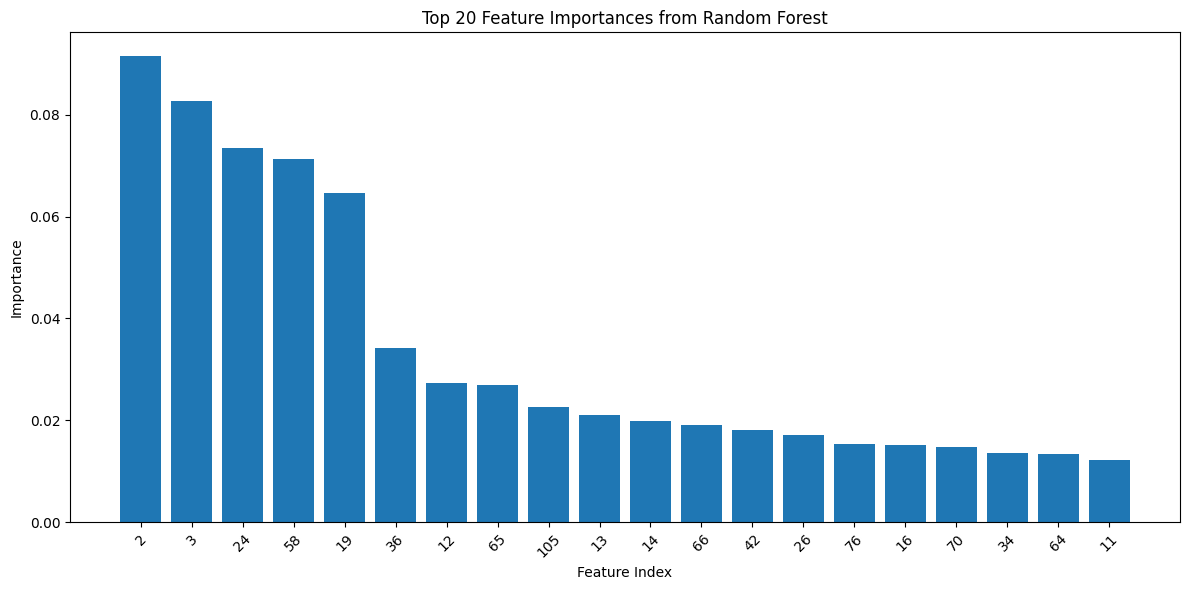

In [21]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()
rf.fit(train_X, train_Y)
importances = rf.feature_importances_

feature_indices = np.argsort(rf.feature_importances_)[::-1][:20]  # Lấy index của top 20

top_importances = rf.feature_importances_[feature_indices]

plt.figure(figsize=(12,6))
plt.bar(range(20), top_importances)
plt.title("Top 20 Feature Importances from Random Forest")
plt.xlabel("Feature Index")
plt.ylabel("Importance")
plt.xticks(range(20), feature_indices, rotation=45)
plt.tight_layout()
plt.show()